<a href="https://colab.research.google.com/github/b4435242/hardware-security/blob/main/dpa_masking.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Break AES using DPA with correlations

You need:
* `plaintext.txt`: all PT blocks, (one block per line, in hex, bytes separated by spaces)
* `ciphertext.txt`: all CT blocks, (one block per line, in hex, bytes separated by spaces)
* `traceLength.txt`: how many samples per trace (one decimal number)
* `traces.bin`: raw measured traces, one byte per sample (uint8), all traces together continuously


In [2]:
import matplotlib.pyplot as plt
import scipy
import numpy as np
from google.colab import drive
from scipy.spatial.distance import hamming
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import sys
sys.path.append('/content/drive/Shared/hwb/lab03/SC_python_measurement')

In [4]:
# AES SBOX
sbox = np.array([
    0x63, 0x7C, 0x77, 0x7B, 0xF2, 0x6B, 0x6F, 0xC5, 0x30, 0x01, 0x67, 0x2B, 0xFE, 0xD7, 0xAB, 0x76,
    0xCA, 0x82, 0xC9, 0x7D, 0xFA, 0x59, 0x47, 0xF0, 0xAD, 0xD4, 0xA2, 0xAF, 0x9C, 0xA4, 0x72, 0xC0,
    0xB7, 0xFD, 0x93, 0x26, 0x36, 0x3F, 0xF7, 0xCC, 0x34, 0xA5, 0xE5, 0xF1, 0x71, 0xD8, 0x31, 0x15,
    0x04, 0xC7, 0x23, 0xC3, 0x18, 0x96, 0x05, 0x9A, 0x07, 0x12, 0x80, 0xE2, 0xEB, 0x27, 0xB2, 0x75,
    0x09, 0x83, 0x2C, 0x1A, 0x1B, 0x6E, 0x5A, 0xA0, 0x52, 0x3B, 0xD6, 0xB3, 0x29, 0xE3, 0x2F, 0x84,
    0x53, 0xD1, 0x00, 0xED, 0x20, 0xFC, 0xB1, 0x5B, 0x6A, 0xCB, 0xBE, 0x39, 0x4A, 0x4C, 0x58, 0xCF,
    0xD0, 0xEF, 0xAA, 0xFB, 0x43, 0x4D, 0x33, 0x85, 0x45, 0xF9, 0x02, 0x7F, 0x50, 0x3C, 0x9F, 0xA8,
    0x51, 0xA3, 0x40, 0x8F, 0x92, 0x9D, 0x38, 0xF5, 0xBC, 0xB6, 0xDA, 0x21, 0x10, 0xFF, 0xF3, 0xD2,
    0xCD, 0x0C, 0x13, 0xEC, 0x5F, 0x97, 0x44, 0x17, 0xC4, 0xA7, 0x7E, 0x3D, 0x64, 0x5D, 0x19, 0x73,
    0x60, 0x81, 0x4F, 0xDC, 0x22, 0x2A, 0x90, 0x88, 0x46, 0xEE, 0xB8, 0x14, 0xDE, 0x5E, 0x0B, 0xDB,
    0xE0, 0x32, 0x3A, 0x0A, 0x49, 0x06, 0x24, 0x5C, 0xC2, 0xD3, 0xAC, 0x62, 0x91, 0x95, 0xE4, 0x79,
    0xE7, 0xC8, 0x37, 0x6D, 0x8D, 0xD5, 0x4E, 0xA9, 0x6C, 0x56, 0xF4, 0xEA, 0x65, 0x7A, 0xAE, 0x08,
    0xBA, 0x78, 0x25, 0x2E, 0x1C, 0xA6, 0xB4, 0xC6, 0xE8, 0xDD, 0x74, 0x1F, 0x4B, 0xBD, 0x8B, 0x8A,
    0x70, 0x3E, 0xB5, 0x66, 0x48, 0x03, 0xF6, 0x0E, 0x61, 0x35, 0x57, 0xB9, 0x86, 0xC1, 0x1D, 0x9E,
    0xE1, 0xF8, 0x98, 0x11, 0x69, 0xD9, 0x8E, 0x94, 0x9B, 0x1E, 0x87, 0xE9, 0xCE, 0x55, 0x28, 0xDF,
    0x8C, 0xA1, 0x89, 0x0D, 0xBF, 0xE6, 0x42, 0x68, 0x41, 0x99, 0x2D, 0x0F, 0xB0, 0x54, 0xBB, 0x16
    ], dtype='uint8')

# Hamming weight lookup table
hw_table = []
for i in range(256):
    s = '{0:08b}'.format(i)
    hw_table.append(s.count('1'))
hw_table = np.array(hw_table, 'uint8')


def hamming_distance_matrix(matrix1, matrix2):
    # ensure the two matrices have the same shape
    assert matrix1.shape == matrix2.shape, "Matrices must have the same shape"

    # initialize the distance matrix
    distance_matrix = np.zeros(matrix1.shape)

    # iterate over the rows and columns of the matrices
    for i in range(matrix1.shape[0]):
        for j in range(matrix1.shape[1]):
            # calculate the Hamming distance between the elements at the same position
            r = (1 << np.arange(8))[:,None]
            distance_matrix[i, j] = np.count_nonzero(matrix1[i, j]&r != matrix2[i, j]&r)

    return distance_matrix


# Correlation of two matrices
def correlate(x, y):
    """
    Correlate all columns from matrix x of shape (a,b)
    with all columns from matrix y of shape (a,c),
    creating correlation matrix C of shape (b,c).
    
    Originally matlab script by Jiri Bucek in NI-HWB.
    """
    x = x - np.average(x, 0) # remove vertical averages
    y = y - np.average(y, 0) # remove vertical averages
    C = x.T @ y              # (n-1) Cov(x,y)
    C = C / (np.sum(x**2, 0)**(1/2))[:,np.newaxis] # divide by (n-1) Var(x)
    C = C / (np.sum(y**2, 0)**(1/2))               # divide by (n-1) Var(y)
    return C

# Load PT of CT from file
def load_text(file_name):
    """
    Load any text PT/CT from file containing hex strings with bytes 
    separated by spaces, one block per line
    Output is a matrix of bytes (np.array)
    """
    txt_str = open(file_name).readlines()
    #del txt_str[-1] #discard last empty line
    #split each line into bytes and convert from hex
    txt_bytes_list = list(
        map(lambda line: 
                list(
                    map(lambda s: int(s, 16),
                        line.rstrip().split(" "))
                ),
            txt_str)
        )
    return np.array(txt_bytes_list, 'uint8')

def trace_compression(traces, num):
  return scipy.signal.resample(traces, num, axis=1)
  
def trace_alignment(traces):
  first_trace = traces[0]
  lags = []
  for i, trace in enumerate(traces):
    cross_corr = scipy.signal.correlate(first_trace, trace)
    lag = np.argmax(cross_corr) - (trace.shape[0]+1)
    lags.append(lag)
  # Set traces aligned to the most left point
  print(lags)
  most_left = min(lags)
  for i, trace in enumerate(traces):
    shift = lags[i] - most_left
    traces[i] = np.pad(trace[shift:], (0, shift), mode='constant') #shift and pad 0 at the end

  return traces

def trace_integration(traces, k):
  _traces = np.zeros((traces.shape[0], traces.shape[1]-k))
  for i, trace in enumerate(traces):
    trace_integrated = np.zeros(trace.shape[0]-k)
    sum = 0
    for j in range(0, k+1):
      sum += trace[j]
    trace_integrated[0] = sum
    for j in range(k+1, trace.shape[0]):
      sum += trace[j]
      sum -= trace[j-k-1]
      trace_integrated[j-k] = sum
    _traces[i] = trace_integrated
  return _traces    

def trace_preprocess(traces, d):
  pre = np.zeros((traces.shape[0],0))
  for i in range(0, traces.shape[1]-d):
   pre = np.concatenate((pre, abs(traces[:, i+1:i+1+d]-traces[:, i:i+1])), axis=1)
  return pre

In [5]:


# read plaintext inputs
inputs = load_text("/content/drive/MyDrive/lab08/plaintext.txt")

# read length of one complete trace (number of samples per trace)
with open("/content/drive/MyDrive/lab08/traceLength.txt", "r") as fin:
  trace_length = int(fin.readline())


# trim each trace - select interesting part
start = 705000
end = 715000 # CHANGE to the length of the first round; 

# read traces from binary file
raw_traces = np.fromfile("/content/drive/MyDrive/lab08/traces.bin", dtype='uint8') # read as linear array
raw_traces = np.reshape(raw_traces, (raw_traces.size // trace_length, trace_length)) # reshape into matrix
raw_traces = raw_traces[:, start:end] # select only the interesting part of each trace


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 511.6/511.6 kB 9.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 48.5 MB/s eta 0:00:00


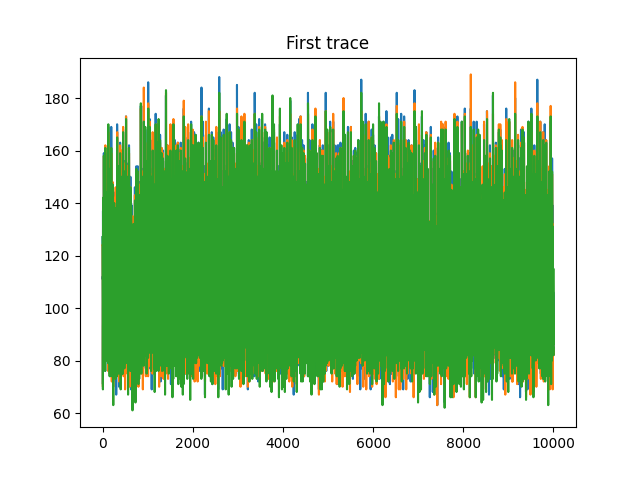

In [6]:
!pip install ipympl
%matplotlib widget
from google.colab import output
output.enable_custom_widget_manager()
fig=plt.figure()
plt.plot(raw_traces[[0, 99, 199]].T) # plotting a vector
plt.title("First trace")
plt.show()

In [7]:
print(inputs.shape) # dimensions of inputs
print(trace_length)
print(raw_traces.shape) # dimensions of matrix of traces

(1000, 16)
1562500
(1000, 10000)


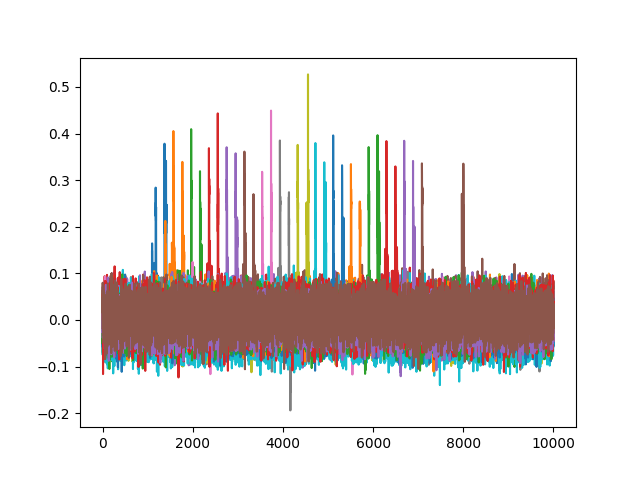

In [8]:
hw_model = hw_table[inputs]
R = correlate(hw_model, raw_traces)
fig = plt.figure()
plt.plot(R.T)
plt.show()

In [9]:

traces_compressed = trace_compression(raw_traces, 1000)




In [10]:
traces_preprocessing = trace_preprocess(traces_compressed, 50)
print(traces_preprocessing.shape)
traces = traces_preprocessing

(1000, 47500)


In [11]:

'''traces_compressed = trace_compression(raw_traces, 40000)
#print(traces_compressed.shape)
traces_integrated = trace_integration(traces_compressed, 10)

#traces_integrated = trace_integration(raw_traces, 100)
print(traces_integrated)
#traces_aligned = trace_alignment(traces_compressed)
#traces_aligned = trace_alignment(raw_traces)
traces_aligned = trace_alignment(traces_integrated)

print(traces_aligned.shape)
traces = traces_aligned'''

'traces_compressed = trace_compression(raw_traces, 40000)\n#print(traces_compressed.shape)\ntraces_integrated = trace_integration(traces_compressed, 10)\n\n#traces_integrated = trace_integration(raw_traces, 100)\nprint(traces_integrated)\n#traces_aligned = trace_alignment(traces_compressed)\n#traces_aligned = trace_alignment(raw_traces)\ntraces_aligned = trace_alignment(traces_integrated)\n\nprint(traces_aligned.shape)\ntraces = traces_aligned'

In [12]:
# If you feel brave enough -- interactive plots
#!pip install ipympl
#from google.colab import output
#output.enable_custom_widget_manager()
#%matplotlib widget

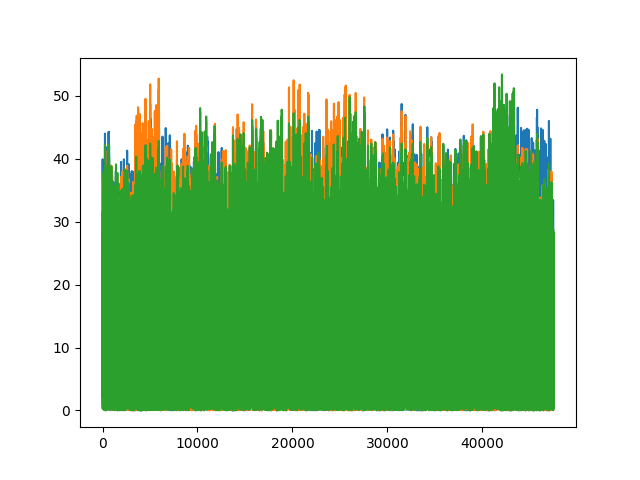

In [13]:
# Plot one trace
fig = plt.figure()
plt.plot(traces[[0, 3, 5]].T)
plt.show()

In [14]:
traces = traces[:, :]

## **Attack the first key byte**
![Intermediate value](dpa-aes-v.png)


In [15]:
# Generate key hypotheses (all possible byte values)
keys = np.arange(start=0, stop=256, step=1, dtype='uint8')
# Select the first byte of each input block
inp = inputs[:, 0]
# XOR each data byte with each key
xmat = inp[:, np.newaxis] ^ keys

In [16]:
# Examine the inputs matrix. Does it contain the data from plaintext.txt?
print(inputs)
# What is the shape of all the operands from the previous cell?
print(inputs.shape)
print(inp.shape)
print(inp[:, np.newaxis].shape)
print(keys.shape)
print(xmat.shape)
# Do you understand the values after the XOR operation? What AES operation do they represent?
print(xmat)

[[181  80 133 ...  62 217  89]
 [170   4 181 ...  99  50 128]
 [238 249 246 ...  39 154 170]
 ...
 [104 216 252 ... 138 148  43]
 [113 175 170 ... 123 240 125]
 [115  78 107 ...  93  28   4]]
(1000, 16)
(1000,)
(1000, 1)
(256,)
(1000, 256)
[[181 180 183 ...  72  75  74]
 [170 171 168 ...  87  84  85]
 [238 239 236 ...  19  16  17]
 ...
 [104 105 106 ... 149 150 151]
 [113 112 115 ... 140 143 142]
 [115 114 113 ... 142 141 140]]


In [17]:
# Substitute with SBOX all XORed values -- matrix of intermediate values
smat = sbox[xmat]

In [18]:
# Compute Hamming Weights -- the matrix of hypothetical power consumption
def power_model(model, smat, xmat):
  if model=="hw":
    return hw_table[smat]
  elif model=="hd":
    return hamming_distance_matrix(smat, xmat)
  elif model=="hw_of_s_x":
    return hw_table[smat^xmat]
  else:
    return smat

[[2 4 4 ... 3 5 4]
 [2 4 4 ... 2 4 4]
 [4 2 2 ... 5 5 4]
 ...
 [4 2 3 ... 7 2 5]
 [4 2 6 ... 4 6 5]
 [6 3 4 ... 5 3 4]]
(1000, 256)
(1000, 47500)
max_acorr 0.184519
key: 35 time: 7067
key: #, 23


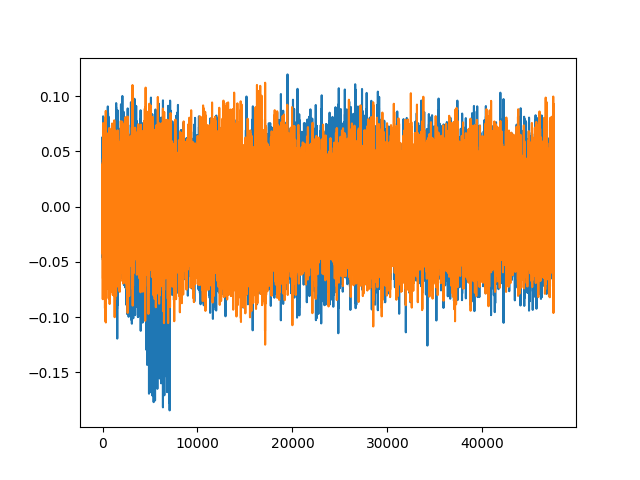

In [19]:
# Compute the correlation matrix -- correlate the hypotheses with measured traces
mat = power_model("hw_of_s_x", smat, xmat)
print(mat)
print(mat.shape)
print(traces.shape)
corr = correlate(mat, traces) 
# What is the shape and contents of the correlation matrix?
# Find the absolute maximum correlation
acorr = abs(corr)
max_acorr = acorr.max()
(k, j) = np.where(acorr == max_acorr) # find idices of maximum
print("max_acorr %f" % max_acorr)
print("key: %d time: %d" % (k[0], j[0]))
print("key: %1c, %02x" % (k[0], k[0]))
# Plot the correlation traces for the right key byte guess and one wrong key byte guess
# Do you see the correlation peaks?
fig = plt.figure()
plt.plot(corr[k[0]])
plt.plot(corr[k[0]+1])
plt.show()

## **Break all key bytes!**

In [20]:
def attack(inp, model):
  # Generate key hypotheses (all possible byte values)
  keys = np.arange(start=0, stop=256, step=1, dtype='uint8')
  # XOR each data byte with each key
  xmat = inp[:, np.newaxis] ^ keys
  # Substitute with SBOX all XORed values -- matrix of intermediate values
  smat = sbox[xmat]
  
  mat = power_model(model, smat, xmat)
  corr = correlate(mat, traces) 
  # What is the shape and contents of the correlation matrix?
  # Find the absolute maximum correlation
  acorr = abs(corr)
  max_acorr = acorr.max()
  (k, j) = np.where(acorr == max_acorr) # find idices of maximum
  return k, j

In [21]:
print(inputs)

[[181  80 133 ...  62 217  89]
 [170   4 181 ...  99  50 128]
 [238 249 246 ...  39 154 170]
 ...
 [104 216 252 ... 138 148  43]
 [113 175 170 ... 123 240 125]
 [115  78 107 ...  93  28   4]]


In [23]:

kk = np.zeros(16, dtype='uint8')

for i in range(0, 16):
    inp = inputs[:, i]
    k, j = attack(inp, "hw_of_s_x")
    kk[i] = k[0]
    print("%1c, %02x @ %d" % (k[0], k[0], j[0]))
print(kk)

#, 23 @ 7067
, 03 @ 7938
ö, f6 @ 10901
L, 4c @ 11831
, 83 @ 12525
B, 42 @ 28861
R, 52 @ 17556
v, 76 @ 38946
³, b3 @ 22843
¢, a2 @ 24813
D, 44 @ 24870
, 7f @ 27376
!, 21 @ 36174
i, 69 @ 32672
¤, a4 @ 31585
L, 4c @ 10067
[ 35   3 246  76 131  66  82 118 179 162  68 127  33 105 164  76]


## **Verify the key on a PT, CT pair!**

In [24]:
key_bytes = bytes(kk)
outputs = load_text("/content/drive/MyDrive/lab08/ciphertext.txt")

In [25]:
!pip install pycryptodome
from Crypto.Cipher import AES
cipher = AES.new(key_bytes, AES.MODE_ECB)
msh = cipher.encrypt(bytes(inputs))
outputs = bytes(outputs)
print("Equal = {} \nct is {}\nencrypted pt is {}".format(outputs==msh ,outputs, msh))

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 22.3 MB/s eta 0:00:00
Equal = False 
ct is b'\xea\x112IA6\x9b\xec\x91\xcdyHBVi\n\n\xcck\xdd\x1d\xf1\x1d\x18$5\xd6\xef\x1b~G\x1ek\xa1\xdf\xc4vW\xb2h\x17\xf8\r N\xb5gH k\xa8\xaeY\x05\x9bQe\x92\xf5u\xf8\xe0\xde\xcf-s\x87\x8d\xe7\x8bX\xf0\xb4<\x01\x10\xc6]2\xb3iV\x94\x9bqNB\xc9\t\x18\'\xd3/\x02\xc6\r&\xb9;UG\xee(/\x97\xd9\xcf\x1dV\x04\xdbz\x90\xa6\xf9\x19\x9a\xb6\xa9\xd4\xe0y\xd0\xc4\x1f?\x1b\x1d\x88\xb7\xef\xc1\x86\x14\xf0n\n2\xa3\xde\xf6\xcb\xa1\x00ha<\x94b6\x89\x14.\xc9\xa0\x12\xca{\xbb\xaf\xa1B\x8c\x97B\xddt\xa2#\xf4<\xfd\x81}Be\xeb \xdb;)C\xc2MEv\xe3\x94\x94Z\xa3\xd8\xa4@\xbdJE~,\x7f\xe7\xbdx#\x15\xd9\xdf\xa5\xdc\x88}\n\xe5Px\xaf\xe6k\x93\x06\xd26\xfd\xe8\xc8\x17\x92\x1fID\x05\xa6\x13Y<i\x13\x92\x06T\x1f%\x93\x7f\xf5\r\xc7\x12\x91\xe97\x80\xbf\x83\'\xb0\xa5\xf2\xa6\xb5\xd6\xa8K9c\x08r%\xce?\xc4D@s\xd6v\xe3~b\x1a5\xd9\x19\xf2S\xd2\x

## **PGE**

In [26]:
def PGE(inp, model, traces):
  # Generate key hypotheses (all possible byte values)
  keys = np.arange(start=0, stop=256, step=1, dtype='uint8')
  # XOR each data byte with each key
  xmat = inp[:, np.newaxis] ^ keys
  # Substitute with SBOX all XORed values -- matrix of intermediate values
  smat = sbox[xmat]
  
  mat = power_model(model, smat, xmat)
  corr = correlate(mat, traces) 
  # What is the shape and contents of the correlation matrix?
  # Find the absolute maximum correlation
  acorr = abs(corr)
  max_corr_table = np.zeros(256)
  for i, corr_of_key in enumerate(acorr):
    max_corr_table[i] = corr_of_key.max()

  pge = max_corr_table.argsort()[::-1]
  return pge

  

In [27]:
traces_num = [50,100,200,500]
models = ["hw","hd","byte"]
for trace_num in traces_num:
  sub_traces = traces[:trace_num]
  sub_inputs = inputs[:trace_num]
  for model in models:
    for i in range(0, 16):
        inp = sub_inputs[:, i]
        pge_table = PGE(inp, model, sub_traces)
        pge = np.where(pge_table==kk[i])[0][0]
        print("PGE for {} round is {}".format(i, pge))
        #print(pge[0])



PGE for 0 round is 217
PGE for 1 round is 136
PGE for 2 round is 106
PGE for 3 round is 167
PGE for 4 round is 212
PGE for 5 round is 14
PGE for 6 round is 73
PGE for 7 round is 11
PGE for 8 round is 50


KeyboardInterrupt: ignored